<a href="https://colab.research.google.com/github/matjesg/bioimage_analysis/blob/master/1_train_and_select.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip freeze > requirements.txt

In [1]:
#@title Set up Google Colab environment
#@markdown Please run this cell to get started.
%tensorflow_version 1.x
#!pip install tensorflow-gpu==1.14
!git clone https://github.com/matjesg/bioimage_analysis.git
!pip install simpleITK
%cd bioimage_analysis
import os
import numpy as np
import pandas as pd
from skimage import io
import keras.backend as K
from unet import unet, preproc, lrfinder, utils
from sklearn.model_selection import StratifiedKFold

TensorFlow 1.x selected.
Cloning into 'bioimage_analysis'...
remote: Enumerating objects: 697, done.
remote: Counting objects: 100% (697/697), done.
remote: Compressing objects: 100% (657/657), done.
remote: Total 697 (delta 52), reused 677 (delta 38), pack-reused 0
Receiving objects: 100% (697/697), 41.99 MiB | 34.15 MiB/s, done.
Resolving deltas: 100% (52/52), done.
     |████████████████████████████████| 42.5MB 75kB/s 
/content/bioimage_analysis


Using TensorFlow backend.


# Traing and model selection pipeline 

## Set parameters 
__Laboratory, consensus strategy, and model weights__
- `LAB`: one of `inns1`, `inns2`, `mue`, `wue1`, `wue2`
- `STRATEGY`: `consensus` or expert_x (e.g., `expert_1`) models
- `PRETRAINED_WEIGHTS`: weights for model initialization (`None` for random initialization)

In [2]:
LAB = 'wue2'
STRATEGY = 'consensus'
PRETRAINED_WEIGHTS = None

# Other parameters as used in our paper
BATCH_SIZE = 4
TILE_SHAPE = (540,540)
PADDING = (184,184)

# Loss weights calculation
LAMBDA = 50 
V_BAL = 0.1 
SIGMA_BAL = 10 
SIGMA_SEP = 6

## Load and prepare data

In [3]:
DATA_PATH = "train_data/lab-{}/images/".format(LAB)
MASK_PATH = "train_data/lab-{}/labels/".format(LAB)
EXPERTS = [x for x in os.listdir(MASK_PATH) if x.startswith('expert')]
LABEL_TYPE = os.listdir(os.path.join(MASK_PATH,EXPERTS[0]))[0].split('_')[1][:-4]

# Get IDs
file_ids = [x.rsplit('.',1)[0] for x in os.listdir(DATA_PATH)]

# Load images
images = [np.expand_dims(io.imread(os.path.join(DATA_PATH, x), as_gray=True), axis=2)
          for x in [s + '.png' for s in file_ids]]

# Load expert segmentation masks
mask_dict = {}
for exp in EXPERTS:
    mask_dict[exp] = [io.imread(os.path.join(MASK_PATH, exp, x), as_gray=True).astype('int')//255 
                      for x in [s + '_' + LABEL_TYPE + '.png' for s in file_ids]]

# Load consensus (STAPLE)
mask_dict['consensus'] = [io.imread(os.path.join(MASK_PATH, 'est_GT', x), as_gray=True).astype('int')//255 
                          for x in [s + '_' + LABEL_TYPE + '.png' for s in file_ids]]

## (Re-)compute consensus with simple ITK, if necassary
# mask_dict['consensus'] = [utils.staple([mask_dict[exp][i] for exp in EXPERTS]) for i in range(len(file_ids))]

# Create generator
data = [{'rawdata': img, 'element_size_um': [1, 1]} for img in np.array(images)]
gen = preproc.DataAugmentationGenerator(data = data, 
                                        classlabels=np.array(mask_dict[STRATEGY]),
                                        tile_shape = TILE_SHAPE, 
                                        padding= PADDING,
                                        batch_size = 2, # only for learning rate finder
                                        n_classes=2,
                                        rotation_range_deg=(0, 360),
                                        flip=False,
                                        deformation_grid=(150, 150),
                                        deformation_magnitude=(10, 10),
                                        value_minimum_range=(0, 0),
                                        value_maximum_range=(0.0, 1),
                                        value_slope_range=(1, 1),
                                        shuffle=True,
                                        foreground_dist_sigma_px=SIGMA_BAL,
                                        border_weight_sigma_px=SIGMA_SEP,
                                        border_weight_factor=LAMBDA,
                                        foreground_background_ratio=V_BAL
                                        )

  0%|          | 0/5 [00:00<?, ?it/s]

Processing training samples


100%|██████████| 5/5 [00:20<00:00,  4.20s/it]


## Training procedure

1. Splitting the data into train and validation set (random stratified sampling)
1. Determining the learning rate using the learning rate finder (Smith, 2018)
1. Training the model with cyclical learning rates according to the fit-one-cycle policy of Smith (2018)

### Learning Rate Finder
Examplary use, results may vary (see  Smith, (2018))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output softmax_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_1.
  'be expecting any data to be passed to {0}.'.format(name))


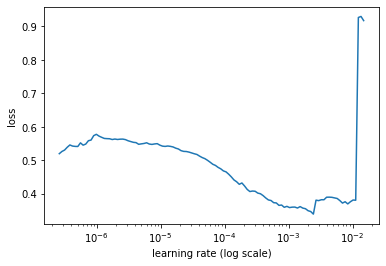

In [4]:
# Create model
model = unet.Unet2D(snapshot=PRETRAINED_WEIGHTS)

# Create and run Learning Rate Finder
lrfind = lrfinder.LRFinder(model.trainModel)
lrfind.find(gen, start_lr=1e-7, lr_mult=1.1, verbose=0)

# Plot loss
lrfind.plot_loss()

# Free GPU Memory
sess = K.get_session()
K.clear_session()
sess.close()

### Training Loop

We used 
- `SEED` to shuffle train-/validation data (defines the ensemble number, e.g. wue1_ __consensus2__ _model1 for `SEED=2`)) 
- stratified k-fold cross-validation (the fold later defines the model number, e.g. wue1_consensus2_ __model1__)
- `max_lr = 5e-4` for _lab-wue1_ and `max_lr = 1e-4` for all other labs as maximum learning rate, according to the learning rate finder
- a cycle length of 972 iterations (27 epochs)
    - For faster computation, we randomly sampled 9 (_lab-wue1_) or 36 (other labs) tiles from each augmented image in each epoch

We predicted validation images from the saved model weights after each epoch for the post-hoc evaluation. Validation during training was based on image tiles only.

In [6]:
SEED = 1
skf = StratifiedKFold(n_splits= 4 if LAB == 'wue1' else 5, 
                      random_state=SEED, shuffle=True)

# Define properties for stratified sampling
if LAB == 'wue1': 
    strata = pd.read_csv('train_data/lab-wue1/groups_wue1.csv', dtype='str')
else: 
    strata = pd.DataFrame({'file_id': file_ids, 'group_id':0})

pred_dict = {}
fold = 0
for train_index, val_index in skf.split(strata['file_id'], strata['group_id']):
    fold += 1
    name = LAB + '_' + STRATEGY + str(SEED) + '_' + str(fold) 
    print(name)
    
    # Split training and validation data
    X_train_cv, X_val_cv = np.array(images)[train_index], np.array(images)[val_index]
    masks = mask_dict[STRATEGY]
    y_train_cv, y_val_cv = np.array(masks)[train_index], np.array(masks)[val_index]
    W_train_cv = np.array(gen.weights)[train_index]
    data_train_cv = [{'rawdata': img, 'element_size_um': [1, 1]} for img in X_train_cv]
    data_val_cv = [{'rawdata': img, 'element_size_um': [1, 1]} for img in X_val_cv]

    # Create train generator
    train_generator = preproc.DataAugmentationGenerator(data = data_train_cv, 
                                                classlabels=y_train_cv,
                                                instancelabels=None,
                                                tile_shape = TILE_SHAPE, 
                                                padding= PADDING,
                                                batch_size = 4,
                                                n_classes=2,
                                                ignore=None,
                                                weights=list(W_train_cv),
                                                element_size_um=None,
                                                rotation_range_deg=(0, 360),
                                                flip=False,
                                                deformation_grid=(150, 150),
                                                deformation_magnitude=(10, 10),
                                                value_minimum_range=(0, 0),
                                                value_maximum_range=(0.0, 1),
                                                value_slope_range=(1, 1),
                                                shuffle=True,
                                                foreground_dist_sigma_px=SIGMA_BAL,
                                                border_weight_sigma_px=SIGMA_SEP,
                                                border_weight_factor=LAMBDA,
                                                foreground_background_ratio=V_BAL)
    # Create validation generator
    tile_generator_val = preproc.TileGenerator(data_val_cv, TILE_SHAPE, PADDING, 
                                           classlabels=y_val_cv,
                                           foreground_dist_sigma_px=SIGMA_BAL,
                                           border_weight_sigma_px=SIGMA_SEP,
                                           border_weight_factor=LAMBDA,
                                           foreground_background_ratio=V_BAL)
    
    # Create model
    model = unet.Unet2D(snapshot=PRETRAINED_WEIGHTS, name=name)

    # Fit model
    model.fit_one_cycle(train_generator, 
                        max_lr = 5e-4 if LAB == 'wue1' else 1e-4,
                        final_epoch = 12 if LAB == 'wue1' else 27,
                        validation_generator= tile_generator_val, 
                        snapshot_dir = '_cp/fold'+str(fold),
                        snapshot_prefix=name,
                        step_muliplier=9 if LAB == 'wue1' else 36)

    # Free GPU Memory
    sess = K.get_session()
    K.clear_session()
    sess.close()

    # Get checkpoint names
    cps = sorted([x for x in os.listdir('_cp/fold'+str(fold)) if x.startswith(name)])
    file_ids_val = list(np.array(file_ids)[val_index])

    # Predict validation images for post-hoc evaluation
    for cp in sorted(cps):
        print(cp)
        pred_model = unet.Unet2D(snapshot=os.path.join('_cp/fold'+str(fold), cp))
        predictions = pred_model.predict(tile_generator_val)   
        for i, idx in enumerate(file_ids_val):           
            pred_dict[(cp, idx)] = predictions[1][i]
        
        # Free GPU Memory
        sess = K.get_session()
        K.clear_session()
        sess.close()

100%|██████████| 4/4 [00:00<00:00, 56.44it/s]

wue2_consensus1_1
Processing training samples



  0%|          | 0/1 [00:00<?, ?it/s]

Processing test samples


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]
/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output softmax_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_1.
  'be expecting any data to be passed to {0}.'.format(name))
/content/bioimage_analysis/unet/unet.py:226: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  callbacks=callbacks)
/content/bioimage_analysis/unet/unet.py:226: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<unet.prep..., steps_per_epoch=36.0

Epoch 1/2
36/36 [==============================] - 110s 3s/step - loss: 0.3170 - val_loss: 0.5203
Epoch 2/2
36/36 [==============================] - 86s 2s/step - loss: 0.1649 - val_loss: 0.2238
wue2_consensus1_1.0001.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output softmax_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_1.
  'be expecting any data to be passed to {0}.'.format(name))
100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


wue2_consensus1_1.0002.h5


100%|██████████| 4/4 [00:00<00:00, 57.24it/s]


wue2_consensus1_2
Processing training samples


  0%|          | 0/1 [00:00<?, ?it/s]

Processing test samples


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]
/content/bioimage_analysis/unet/unet.py:226: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  callbacks=callbacks)
/content/bioimage_analysis/unet/unet.py:226: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<unet.prep..., steps_per_epoch=36.0, epochs=2, initial_epoch=0, validation_data=<unet.prep..., verbose=True, callbacks=[<keras.ca..., validation_steps=9)`
  callbacks=callbacks)


Epoch 1/2
36/36 [==============================] - 90s 3s/step - loss: 0.5217 - val_loss: 0.5151
Epoch 2/2
36/36 [==============================] - 86s 2s/step - loss: 0.1881 - val_loss: 0.1837
wue2_consensus1_2.0001.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output softmax_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_1.
  'be expecting any data to be passed to {0}.'.format(name))
100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


wue2_consensus1_2.0002.h5


100%|██████████| 4/4 [00:00<00:00, 49.86it/s]


wue2_consensus1_3
Processing training samples


  0%|          | 0/1 [00:00<?, ?it/s]

Processing test samples


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]
/content/bioimage_analysis/unet/unet.py:226: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  callbacks=callbacks)
/content/bioimage_analysis/unet/unet.py:226: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<unet.prep..., steps_per_epoch=36.0, epochs=2, initial_epoch=0, validation_data=<unet.prep..., verbose=True, callbacks=[<keras.ca..., validation_steps=9)`
  callbacks=callbacks)


Epoch 1/2
36/36 [==============================] - 90s 3s/step - loss: 0.4830 - val_loss: 0.4454
Epoch 2/2
36/36 [==============================] - 86s 2s/step - loss: 0.1725 - val_loss: 0.1625
wue2_consensus1_3.0001.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output softmax_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_1.
  'be expecting any data to be passed to {0}.'.format(name))
100%|██████████| 9/9 [00:02<00:00,  3.22it/s]


wue2_consensus1_3.0002.h5


100%|██████████| 4/4 [00:00<00:00, 51.18it/s]


wue2_consensus1_4
Processing training samples


  0%|          | 0/1 [00:00<?, ?it/s]

Processing test samples


100%|██████████| 1/1 [00:09<00:00,  9.57s/it]
/content/bioimage_analysis/unet/unet.py:226: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  callbacks=callbacks)
/content/bioimage_analysis/unet/unet.py:226: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<unet.prep..., steps_per_epoch=36.0, epochs=2, initial_epoch=0, validation_data=<unet.prep..., verbose=True, callbacks=[<keras.ca..., validation_steps=9)`
  callbacks=callbacks)


Epoch 1/2
36/36 [==============================] - 90s 3s/step - loss: 0.5029 - val_loss: 0.4711
Epoch 2/2
36/36 [==============================] - 85s 2s/step - loss: 0.1755 - val_loss: 0.2780
wue2_consensus1_4.0001.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output softmax_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_1.
  'be expecting any data to be passed to {0}.'.format(name))
100%|██████████| 9/9 [00:02<00:00,  3.14it/s]


wue2_consensus1_4.0002.h5


100%|██████████| 4/4 [00:00<00:00, 50.70it/s]


wue2_consensus1_5
Processing training samples


  0%|          | 0/1 [00:00<?, ?it/s]

Processing test samples


100%|██████████| 1/1 [00:04<00:00,  4.26s/it]
/content/bioimage_analysis/unet/unet.py:226: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  callbacks=callbacks)
/content/bioimage_analysis/unet/unet.py:226: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<unet.prep..., steps_per_epoch=36.0, epochs=2, initial_epoch=0, validation_data=<unet.prep..., verbose=True, callbacks=[<keras.ca..., validation_steps=9)`
  callbacks=callbacks)


Epoch 1/2
36/36 [==============================] - 90s 2s/step - loss: 0.4393 - val_loss: 0.4422
Epoch 2/2
36/36 [==============================] - 85s 2s/step - loss: 0.1918 - val_loss: 0.1149
wue2_consensus1_5.0001.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output softmax_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_1.
  'be expecting any data to be passed to {0}.'.format(name))
100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


wue2_consensus1_5.0002.h5


100%|██████████| 9/9 [00:02<00:00,  3.35it/s]


## Model Selection

Selecting the model with the highest F1 score on the validation set. We used
- `MIN_PIXEL` to approximate the minimum biologically justifiable size based on the smallest area that was annotated by a human expert 
- `IOU_t=0.5` as IoU threshold

In [7]:
MIN_PIXEL = {'inns1':16, 'inns2':60, 'mue':30, 'wue1':30, 'wue2':112}
IOU_t=0.5

__Similarity analysis and model selection__

In [13]:
res_list = []
for i, idx in enumerate(file_ids):
    # Exclude area from analysis (wue2 only)
    if LAB == 'wue2':
        exclude = [io.imread(os.path.join("train_data/lab-wue2/ignored_regions/", x), as_gray=True)//255 for 
                   x in [idx + '_ignore.png' for s in file_ids]]
        for exp in EXPERTS+['consensus']:
            mask_dict[exp][i][exclude[i]==1]=0
        for cp, idx2 in pred_dict:
            if idx==idx2:
                pred_dict[(cp, idx)][exclude[i]==1]=0

    # Label connected regions
    label_a = utils.label_mask(mask_dict['consensus'][i], min_pixel=MIN_PIXEL[LAB])
    for exp in EXPERTS:
        # Label connected regions
        label_b =  utils.label_mask(mask_dict[exp][i], min_pixel=MIN_PIXEL[LAB])
        # Match ROIs
        tmp_res =  utils.iou_mapping(label_a, label_b, min_roi_size=MIN_PIXEL[LAB])
        df_exp = pd.Series({'FileId' : idx,
                            'Type': 'ref',
                              'cp_name' : exp,
                              'count_a': tmp_res[3], 
                              'count_b': tmp_res[4], 
                              'matches_iou' : tmp_res[0]})
        res_list += [df_exp]
    for cp, idx2 in pred_dict:
        if idx==idx2:
            # Label connected regions
            label_b =  utils.label_mask(pred_dict[(cp, idx)], min_pixel=MIN_PIXEL[LAB])
            # Match ROIs
            tmp_res =  utils.iou_mapping(label_a, label_b, min_roi_size=MIN_PIXEL[LAB])
            df_pred = pd.Series({'FileId' : idx,
                                'Type': 'pred',
                                  'cp_name' : cp,
                                  'count_a': tmp_res[3], 
                                  'count_b': tmp_res[4], 
                                  'matches_iou' : tmp_res[0]})
            res_list += [df_pred]
            
# Compute precision, recall, and F1 score
df = pd.DataFrame(res_list)
df['fold'] = df['cp_name'].str[-9:-8]
df['matches'] =  df['matches_iou'].apply(lambda x : x[x>IOU_t].shape[0] if len(x)>0 else 0)
df['precision'] =  df.matches/df.count_a
df['recall'] = df.matches/df.count_b
df['f1_score'] = 2 * (df.precision * df.recall) / (df.precision + df.recall)

# # filter models below expert reference lower bound
exp_lb = df[df.Type=='ref'].groupby('FileId').f1_score.min()
exp_lb.name = 'f1_lb'
df_pred = df[df.Type=='pred'].join(exp_lb, on='FileId')
#df_pred = df_pred[df_pred.f1_lb<df_pred.f1_score]

# select models with highest f1 score (f1 score median)
df_select = (df_pred.groupby(['fold', 'cp_name'])
             .f1_score.agg(['median', 'count'])
             .reset_index('cp_name')
             .sort_values('median')
             .groupby(['fold'])
             .first().reset_index())
df_select = df_select[df_select['count']==len(val_index)]
df_select['ensemble_model_number'] = df_select.cp_name.str[:-9]+'model'+df_select.fold

# Print models selected for ensembling
df_select[['cp_name', 'ensemble_model_number']]

,cp_name,ensemble_model_number
0,wue2_consensus1_1.0001.h5,wue2_consensus1_model1
3,wue2_consensus1_4.0002.h5,wue2_consensus1_model4
4,wue2_consensus1_5.0002.h5,wue2_consensus1_model5
